# Groundwater Flow Simulation using Finite Difference Method (Semi-Implicit Scheme)

This notebook simulates groundwater flow in a 2D confined aquifer using the Semi-implicit finite difference method. It visualizes the head distribution over time.

## 1. Import Required Libraries

In [3]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.animation as animation

## 2. Define Helper Function for closet node number

This function finds the closest node in the grid given a coordinate.

In [5]:
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)  # Compute squared distance
    return np.argmin(dist_2)  # Return index of closest node

## 3. Define Problem Parameters

In [7]:
# Parameters
Lx = 2000
Ly = 2000
delx =100
dely = 100
T = 10
S = 0.0001
Q = 0.05
t_total = 365
delt = 1  # Adjust for stability!
alpha=0.5


## 4. Create Node Grid

Each node represents a point where we calculate the hydraulic head.

In [9]:
# Number of nodes
n_nodes_x = int(Lx / delx) + 1
n_nodes_y = int(Ly / dely) + 1
numnodes = n_nodes_x * n_nodes_y

# Node coordinates
nodes = []
for i in range(n_nodes_x):
    for j in range(n_nodes_y):
        x_coord = delx * i
        y_coord = dely * j
        nodes.append([x_coord, y_coord])
nodes = np.array(nodes)

## 5. Identify Boundary Nodes

We assume a constant head on the left and right boundaries.

In [11]:
# Boundary node indices
left = np.arange(0, n_nodes_x, 1)
right = np.arange(numnodes - n_nodes_y, numnodes, 1)
bottom = np.arange(n_nodes_y, numnodes - n_nodes_y - 1, n_nodes_y)
top = np.arange(2 * n_nodes_y - 1, numnodes - 1, n_nodes_y)
boundary = np.concatenate((left, right, top, bottom), axis=0)

## 6. Initialize Head Values

In [13]:
# Initialize head
h = np.zeros(numnodes)
h_old = np.zeros(numnodes)+100
h_old[left] = 100
h_old[right] = 100


## 7. Solve for Head Distribution Over Time

We use the implicit finite difference method and solve the linear system at each time step

In [15]:
# Store head values at all time steps
head_history = []
time_history = []

# Implicit time-stepping
t = 0.0
while t <= t_total:
    print(t)
    A = np.zeros((numnodes, numnodes))
    b = np.zeros(numnodes)

    # Interior nodes
    for i in range(numnodes):
        x = nodes[i][0]
        y = nodes[i][1]

        # Coefficient for implicit method
        A[i, i] = alpha*(4*T*delt /(S*delx**2)) + 1 # Diagonal term for implicit method
        if i not in boundary:
            # Use closest_node for finding neighbors
            north_node = closest_node([x, y + dely], nodes)
            south_node = closest_node([x, y - dely], nodes)
            east_node = closest_node([x + delx, y], nodes)
            west_node = closest_node([x - delx, y], nodes)

            # Set coefficients for neighboring nodes
            A[i, north_node] = -alpha*T*delt / (delx**2*S) 
            A[i, south_node] = -alpha*T*delt / (delx**2*S)
            A[i, east_node] = -alpha*T*delt / (delx**2*S)
            A[i, west_node] = -alpha*T*delt / (delx**2*S)
            
            b[i] = h_old[i] + (1-alpha)*(T*delt /(S*delx**2))* (h_old[north_node] + h_old[south_node] + h_old[east_node] + h_old[west_node] - 4 * h_old[i])
            
        

        if i in top:
            south_node = closest_node([x, y - dely], nodes)
            east_node = closest_node([x + delx, y], nodes)
            west_node = closest_node([x - delx, y], nodes)

            A[i, south_node] = -2*alpha*T*delt / (delx**2*S)
            A[i, east_node] = -alpha*T*delt / (delx**2*S)
            A[i, west_node] = -alpha*T*delt / (delx**2*S)
            
            b[i] = h_old[i] + (1-alpha)*(T*delt /(S*delx**2))* (2* h_old[south_node] + h_old[east_node] + h_old[west_node] - 4 * h_old[i])

        if i in bottom:
            north_node = closest_node([x, y + dely], nodes)
            east_node = closest_node([x + delx, y], nodes)
            west_node = closest_node([x - delx, y], nodes)

            A[i, north_node] = -alpha*2*T*delt / (delx**2*S)
            A[i, east_node] = -alpha*T*delt / (delx**2*S)
            A[i, west_node] = -alpha*T*delt / (delx**2*S)
            
            b[i] = h_old[i] + (1-alpha)*(T*delt /(S*delx**2))* (2* h_old[north_node] + h_old[east_node] + h_old[west_node] - 4 * h_old[i])

    # Injection well
    b[closest_node([400, 400], nodes)]+=-0.03*delt/S 
    b[closest_node([1200, 1200], nodes)]+=0.05*delt /S
    
    # Boundary conditions
    b[left] = 100
    A[left, left] = 1

    b[right] =100
    A[right, right] = 1

    # Solve the system using the implicit method
    h = linalg.solve(A, b)

    # Store head and time
    head_history.append(h.copy())
    time_history.append(t)

    # Update h_old
    h_old = h.copy()

    # Increment time
    t += delt

# Convert head_history to a NumPy array
head_history = np.array(head_history)
time_history = np.array(time_history)


0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
101.0
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0
110.0
111.0
112.0
113.0
114.0
115.0
116.0
117.0
118.0
119.0
120.0
121.0
122.0
123.0
124.0
125.0
126.0
127.0
128.0
129.0
130.0
131.0
132.0
133.0
134.0
135.0
136.0
137.0
138.0
139.0
140.0
141.0
142.0
143.0
144.0
145.0
146.0
147.0
148.0
149.0
150.0
151.0
152.0
153.0
154.0
155.0
156.0
157.0
158.0
159.0
160.0
161.0
162.0
163.0
164.0
165.0
166.0
167.0
168.0
169.0
170.0
171.0
172.0
173.0
174.0
175.0
176.0
177.0
178.0
179.0
180.0
181.0
182.0
183.0
184.0


## 8. Plot Head Distribution at Final Time Step

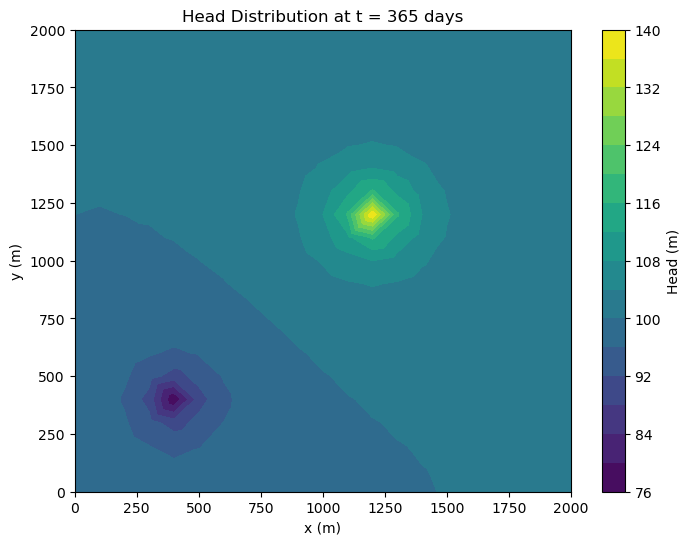

In [17]:
# Plot the last time step
plt.figure(figsize=(8, 6))
plt.tricontourf(nodes[:, 0], nodes[:, 1], head_history[0],20, cmap='viridis')
plt.colorbar(label='Head (m)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(f'Head Distribution at t = {time_history[-1]:.0f} days')
plt.show()


## 9. Plot Head at a Specific Node Over Time

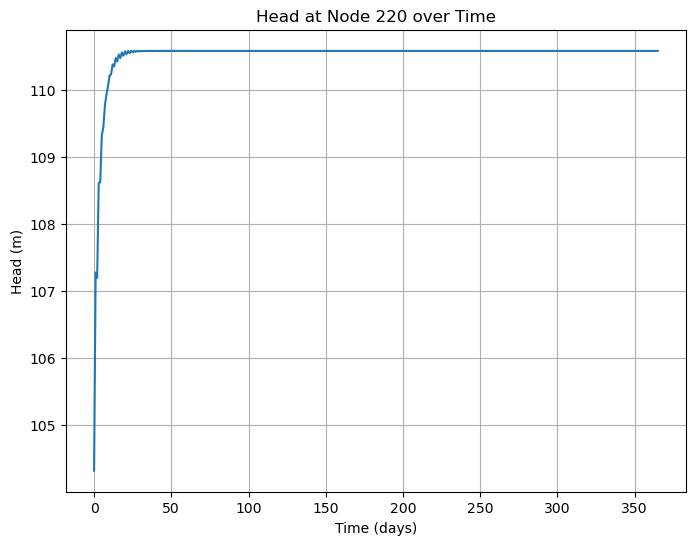

In [19]:
#%%
# Example: Plotting head at a specific node over time:
node_index = closest_node([1000, 1000], nodes) # Example node index
plt.figure(figsize=(8, 6))
plt.plot(time_history, head_history[:, closest_node([1000, 1000], nodes)])
plt.xlabel('Time (days)')
plt.ylabel('Head (m)')
plt.title(f'Head at Node {node_index} over Time')
plt.grid(True)
plt.show()
